In [1]:
## example using the pretrained convnet
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

conv_base.summary()

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

# Two approaches

Running the convolutional base over your dataset will be fast, but won't allow data augmentation.

Or

Extending the model you have (conv_base) by adding Dense layers on top and running the whole thing end to end on the input data. This will allow data augmentation but is expensive.

## Fast feature extraction without data augmentation
Using the ImageDataGenerator to extract images as Numpy arrays as well as their labels.

In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/Users/datascience4/Documents/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [3]:
print(validation_features.shape)

(1000, 4, 4, 512)


In [4]:
## feed them into a dense layer of 8192
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

print(validation_features.shape)

(1000, 8192)


In [5]:
## defining and training the densely connected classifier
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 805us/step - loss: 0.5903 - acc: 0.6830 - val_loss: 0.4438 - val_acc: 0.8210
Epoch 2/30
2000/2000 [==============================] - 1s 738us/step - loss: 0.4181 - acc: 0.8125 - val_loss: 0.3786 - val_acc: 0.8350
Epoch 3/30
2000/2000 [==============================] - 1s 666us/step - loss: 0.3515 - acc: 0.8470 - val_loss: 0.3351 - val_acc: 0.8670
Epoch 4/30
2000/2000 [==============================] - 1s 655us/step - loss: 0.3212 - acc: 0.8625 - val_loss: 0.3135 - val_acc: 0.8700
Epoch 5/30
2000/2000 [==============================] - 1s 706us/step - loss: 0.2893 - acc: 0.8830 - val_loss: 0.3076 - val_acc: 0.8700
Epoch 6/30
2000/2000 [==============================] - 1s 630us/step - loss: 0.2641 - acc: 0.8960 - val_loss: 0.2912 - val_acc: 0.8760
Epoch 7/30
2000/2000 [==============================] - 1s 632us/step - loss: 0.2388 - acc: 0.9125 - val_loss: 0.2831 - val_acc: 0.8800


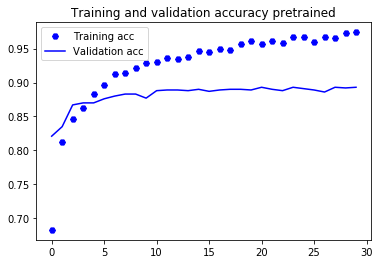

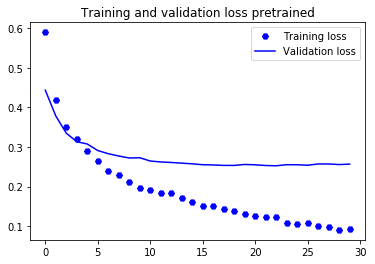

In [8]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bH', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy pretrained')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bH', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss pretrained')
plt.legend()

plt.show()

## Still overfitting
The technique above is overfitting from the beginning. Therefore data augmentation would be useful on a small dataset like this but it would now become computationally expensive. Therefore a GPU is recommended from this point onwards.

You can the pretrained model to a Sequential model because they behave in a similar way to a layer.